# Early-Bird Ticket Discovery on VGG16 + CIFAR-10

This notebook implements the Early-Bird (EB) ticket discovery algorithm from "Drawing Early-Bird Tickets" (You et al., ICLR 2020).

## Configuration
- **Model**: VGG16 with Batch Normalization
- **Dataset**: CIFAR-10
- **Optimizer**: SGD with momentum (0.9) and weight decay (10⁻⁴)
- **Learning Rate**: 0.1, divided by 10 at epochs 80 and 120
- **Total Epochs**: 160
- **Batch Size**: 256
- **Pruning**: Structured channel pruning based on BN γ values
- **Exit Criterion**: Mask Hamming distance < ε (0.1) for 5 consecutive epochs
- **Target Sparsities**: 30%, 50%, 70%

In [ ]:
# Imports and setup
import sys
from pathlib import Path
import copy
from datetime import datetime

# Add project root to path
ROOT_DIR = Path.cwd().parent
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Import our Early-Bird implementation
from src.earlybird import (
    EarlyBirdFinder,
    extract_bn_gammas,
    compute_channel_mask_from_bn_gamma,
    expand_channel_mask_to_conv_weights,
    add_l1_regularization_to_bn,
    get_bn_layer_count,
    get_overall_channel_sparsity,
    get_channel_sparsity,
 )
from src.data import get_cifar10_dataloaders

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## VGG16 Model Definition

VGG16 with Batch Normalization for CIFAR-10. The model follows the standard VGG architecture adapted for 32×32 input images.

In [2]:
class VGG16_BN(nn.Module):
    """VGG16 with Batch Normalization for CIFAR-10."""
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Configuration for VGG16: number of channels per block
        # 2 conv layers with 64 -> 2 with 128 -> 3 with 256 -> 3 with 512 -> 3 with 512
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        
        self.features = self._make_layers(cfg)
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                layers.append(nn.Conv2d(in_channels, x, kernel_size=3, padding=1))
                layers.append(nn.BatchNorm2d(x))
                layers.append(nn.ReLU(inplace=True))
                in_channels = x
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create model and check BN layer count
model = VGG16_BN(num_classes=10).to(device)
bn_count = get_bn_layer_count(model)
print(f"VGG16-BN created with {bn_count} BatchNorm layers")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

VGG16-BN created with 13 BatchNorm layers
Total parameters: 15,253,578


## Data Loading

Load CIFAR-10 with standard data augmentation (random crop, horizontal flip) and normalization.

In [3]:
# Hyperparameters
BATCH_SIZE = 256
NUM_WORKERS = 4

# Get CIFAR-10 dataloaders
train_loader, test_loader = get_cifar10_dataloaders(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    data_dir=ROOT_DIR / 'data'
)

print(f"Training samples: {len(train_loader.dataset):,}")
print(f"Test samples: {len(test_loader.dataset):,}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches per epoch: {len(train_loader)}")

100%|████████████████████████████████████████| 170M/170M [00:01<00:00, 97.1MB/s]


Training samples: 50,000
Test samples: 10,000
Batch size: 256
Training batches per epoch: 196


## Early-Bird Search Configuration

Setup the training and Early-Bird detection parameters according to the paper specifications.

In [4]:
# Training configuration
TOTAL_EPOCHS = 160
INITIAL_LR = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LR_MILESTONES = [80, 120]  # Divide LR by 10 at these epochs
LR_GAMMA = 0.1

# Early-Bird detection configuration
TARGET_SPARSITY = 0.5  # 50% pruning ratio (change to 0.3, 0.5, or 0.7)
DISTANCE_THRESHOLD = 0.1  # ε: Hamming distance threshold
PATIENCE = 5  # Number of consecutive epochs below threshold
L1_COEF = 1e-4  # L1 regularization coefficient for BN γ
PRUNING_METHOD = 'global'  # 'global' or 'layerwise'

print("=" * 60)
print("Early-Bird Search Configuration")
print("=" * 60)
print(f"Target sparsity: {TARGET_SPARSITY * 100:.0f}%")
print(f"Distance threshold (ε): {DISTANCE_THRESHOLD}")
print(f"Patience: {PATIENCE} consecutive epochs")
print(f"L1 coefficient: {L1_COEF}")
print(f"Pruning method: {PRUNING_METHOD}")
print("=" * 60)
print("Training Configuration")
print("=" * 60)
print(f"Total epochs: {TOTAL_EPOCHS}")
print(f"Initial LR: {INITIAL_LR}")
print(f"LR milestones: {LR_MILESTONES}")
print(f"Momentum: {MOMENTUM}")
print(f"Weight decay: {WEIGHT_DECAY}")

Early-Bird Search Configuration
Target sparsity: 50%
Distance threshold (ε): 0.1
Patience: 5 consecutive epochs
L1 coefficient: 0.0001
Pruning method: global
Training Configuration
Total epochs: 160
Initial LR: 0.1
LR milestones: [80, 120]
Momentum: 0.9
Weight decay: 0.0001


## Training Functions

Define the training loop with L1 regularization on BatchNorm γ values for the search phase.

In [5]:
def train_epoch_with_l1(model, train_loader, optimizer, criterion, l1_coef, device):
    """Train for one epoch with L1 regularization on BN γ values."""
    model.train()
    total_loss = 0.0
    total_l1_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Cross-entropy loss
        ce_loss = criterion(outputs, targets)
        
        # L1 regularization on BN γ
        l1_loss = add_l1_regularization_to_bn(model, l1_coef)
        
        # Combined loss
        loss = ce_loss + l1_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += ce_loss.item() * inputs.size(0)
        total_l1_loss += l1_loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    avg_loss = total_loss / total
    avg_l1_loss = total_l1_loss / total
    accuracy = 100.0 * correct / total
    
    return avg_loss, avg_l1_loss, accuracy

def evaluate(model, test_loader, criterion, device):
    """Evaluate model on test set."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy

print("Training functions defined.")

Training functions defined.


## Phase 1: Early-Bird Ticket Search

Train the network with L1 regularization on BN γ values while monitoring mask stability. The search terminates when the Hamming distance between consecutive epoch masks stays below ε for `patience` consecutive epochs.

In [ ]:
# Re-initialize model for fresh start
model = VGG16_BN(num_classes=10).to(device)
initial_model_state = copy.deepcopy(model.state_dict())

# Setup optimizer, scheduler, and criterion
optimizer = optim.SGD(
    model.parameters(),
    lr=INITIAL_LR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)
scheduler = MultiStepLR(optimizer, milestones=LR_MILESTONES, gamma=LR_GAMMA)
criterion = nn.CrossEntropyLoss()

# Initialize Early-Bird finder
eb_finder = EarlyBirdFinder(
    target_sparsity=TARGET_SPARSITY,
    patience=PATIENCE,
    distance_threshold=DISTANCE_THRESHOLD,
    pruning_method=PRUNING_METHOD
)

# Tracking for visualization
history = {
    'epoch': [],
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': [],
    'mask_distance': [],
    'lr': [],
}

print("Starting Early-Bird ticket search...")
print("=" * 70)

Starting Early-Bird ticket search...


In [7]:
# Main training loop for Early-Bird search
convergence_epoch = None

for epoch in range(TOTAL_EPOCHS):
    current_lr = optimizer.param_groups[0]['lr']
    
    # Train one epoch with L1 regularization
    train_loss, l1_loss, train_acc = train_epoch_with_l1(
        model, train_loader, optimizer, criterion, L1_COEF, device
    )
    
    # Evaluate on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Step the scheduler
    scheduler.step()
    
    # Record BN γ and check for Early-Bird convergence
    converged, mask_distance = eb_finder.record_epoch(model, epoch)
    
    # Store history
    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['mask_distance'].append(mask_distance if mask_distance is not None else -1)
    history['lr'].append(current_lr)
    
    # Print progress (every epoch for first 10, then every 5)
    if epoch < 10 or epoch % 5 == 0 or converged:
        dist_str = f"{mask_distance:.4f}" if mask_distance is not None else "N/A"
        print(f"Epoch {epoch:3d} | LR: {current_lr:.4f} | "
              f"Train: {train_acc:.2f}% (Loss: {train_loss:.4f}) | "
              f"Test: {test_acc:.2f}% (Loss: {test_loss:.4f}) | "
              f"Mask Dist: {dist_str}" + 
              (" ← EB Ticket!" if converged else ""))
    
    # Check for convergence
    if converged:
        convergence_epoch = epoch
        print("\n" + "=" * 70)
        print(f"🎫 EARLY-BIRD TICKET FOUND at epoch {epoch}!")
        print("=" * 70)
        break

if convergence_epoch is None:
    print("\n" + "=" * 70)
    print("⚠️  Early-Bird ticket not found within training epochs.")
    print("=" * 70)
    print("Consider: lower distance threshold, higher patience, or more epochs.")
else:
    print(f"\n✓ Search phase complete. Early-Bird ticket emerged at epoch {convergence_epoch}.")
    print(f"✓ Training epochs saved: {TOTAL_EPOCHS - convergence_epoch - 1}")

Epoch   0 | LR: 0.1000 | Train: 26.77% (Loss: 1.8613) | Test: 37.62% (Loss: 1.5924) | Mask Dist: N/A
Epoch   1 | LR: 0.1000 | Train: 46.22% (Loss: 1.4557) | Test: 52.26% (Loss: 1.4071) | Mask Dist: 0.2069
Epoch   2 | LR: 0.1000 | Train: 60.91% (Loss: 1.1338) | Test: 63.52% (Loss: 1.0833) | Mask Dist: 0.1387
Epoch   3 | LR: 0.1000 | Train: 68.28% (Loss: 0.9417) | Test: 69.31% (Loss: 0.8712) | Mask Dist: 0.0971
Epoch   4 | LR: 0.1000 | Train: 73.02% (Loss: 0.8102) | Test: 71.38% (Loss: 0.9213) | Mask Dist: 0.0819
Epoch   5 | LR: 0.1000 | Train: 76.82% (Loss: 0.7137) | Test: 73.36% (Loss: 0.8102) | Mask Dist: 0.0781
Epoch   6 | LR: 0.1000 | Train: 79.15% (Loss: 0.6498) | Test: 74.09% (Loss: 0.8081) | Mask Dist: 0.0677
Epoch   7 | LR: 0.1000 | Train: 81.42% (Loss: 0.5793) | Test: 79.63% (Loss: 0.6253) | Mask Dist: 0.0677 ← EB Ticket!

🎫 EARLY-BIRD TICKET FOUND at epoch 7!

✓ Search phase complete. Early-Bird ticket emerged at epoch 7.
✓ Training epochs saved: 152


In [ ]:
# Save search-phase artifacts (initial model, final model, final masks)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = ROOT_DIR / "results" / "earlybird" / f"earlybird_vgg16_cifar10_s{TARGET_SPARSITY}_{timestamp}"
run_dir.mkdir(parents=True, exist_ok=True)

# Save initial and final model states
torch.save(initial_model_state, run_dir / "initial_model.pt")
torch.save(model.state_dict(), run_dir / "final_model.pt")

# Save final masks (Early-Bird ticket) if available
eb_ticket = eb_finder.get_early_bird_ticket()
if eb_ticket is not None:
    torch.save(eb_ticket, run_dir / "final_masks.pt")
    print("✓ Saved Early-Bird artifacts:")
    print(f"  - Initial model: {run_dir / 'initial_model.pt'}")
    print(f"  - Final model: {run_dir / 'final_model.pt'}")
    print(f"  - Final masks: {run_dir / 'final_masks.pt'}")
else:
    print("✓ Saved Early-Bird artifacts:")
    print(f"  - Initial model: {run_dir / 'initial_model.pt'}")
    print(f"  - Final model: {run_dir / 'final_model.pt'}")
    print("  - Final masks: not available (no EB ticket found)")

## Early-Bird Results Analysis

Examine the discovered Early-Bird ticket and visualize the search process.

In [8]:
# Get Early-Bird statistics
eb_stats = eb_finder.get_statistics()
eb_ticket = eb_finder.get_early_bird_ticket()

print("=" * 70)
print("EARLY-BIRD SEARCH STATISTICS")
print("=" * 70)
print(f"Converged: {eb_stats['converged']}")
print(f"Convergence Epoch: {eb_stats['convergence_epoch']}")
print(f"Total Epochs Recorded: {eb_stats['total_epochs_recorded']}")
print(f"Target Sparsity: {eb_stats['target_sparsity'] * 100:.1f}%")
print(f"Distance Threshold (ε): {eb_stats['distance_threshold']}")
print(f"Patience: {eb_stats['patience']}")

if eb_ticket is not None:
    print("\n" + "=" * 70)
    print("CHANNEL MASK STATISTICS (per BN layer)")
    print("=" * 70)
    sparsity_per_layer = get_channel_sparsity(eb_ticket)
    
    # Print first 5 and last 5 layers
    items = list(sparsity_per_layer.items())
    if len(items) <= 10:
        for name, sparsity in items:
            remaining = (1 - sparsity) * 100
            print(f"  {name}: {sparsity * 100:.2f}% pruned ({remaining:.2f}% remaining)")
    else:
        for name, sparsity in items[:5]:
            remaining = (1 - sparsity) * 100
            print(f"  {name}: {sparsity * 100:.2f}% pruned ({remaining:.2f}% remaining)")
        print(f"  ... ({len(items) - 10} layers omitted) ...")
        for name, sparsity in items[-5:]:
            remaining = (1 - sparsity) * 100
            print(f"  {name}: {sparsity * 100:.2f}% pruned ({remaining:.2f}% remaining)")
    
    overall_sparsity = get_overall_channel_sparsity(eb_ticket)
    print(f"\n  Overall Channel Sparsity: {overall_sparsity * 100:.2f}%")
    print("=" * 70)

EARLY-BIRD SEARCH STATISTICS
Converged: True
Convergence Epoch: 7
Total Epochs Recorded: 8
Target Sparsity: 50.0%
Distance Threshold (ε): 0.1
Patience: 5

CHANNEL MASK STATISTICS (per BN layer)
  features.1: 75.00% pruned (25.00% remaining)
  features.4: 54.69% pruned (45.31% remaining)
  features.8: 48.44% pruned (51.56% remaining)
  features.11: 60.94% pruned (39.06% remaining)
  features.15: 53.52% pruned (46.48% remaining)
  ... (3 layers omitted) ...
  features.28: 37.89% pruned (62.11% remaining)
  features.31: 35.74% pruned (64.26% remaining)
  features.35: 33.40% pruned (66.60% remaining)
  features.38: 40.43% pruned (59.57% remaining)
  features.41: 99.80% pruned (0.20% remaining)

  Overall Channel Sparsity: 50.00%


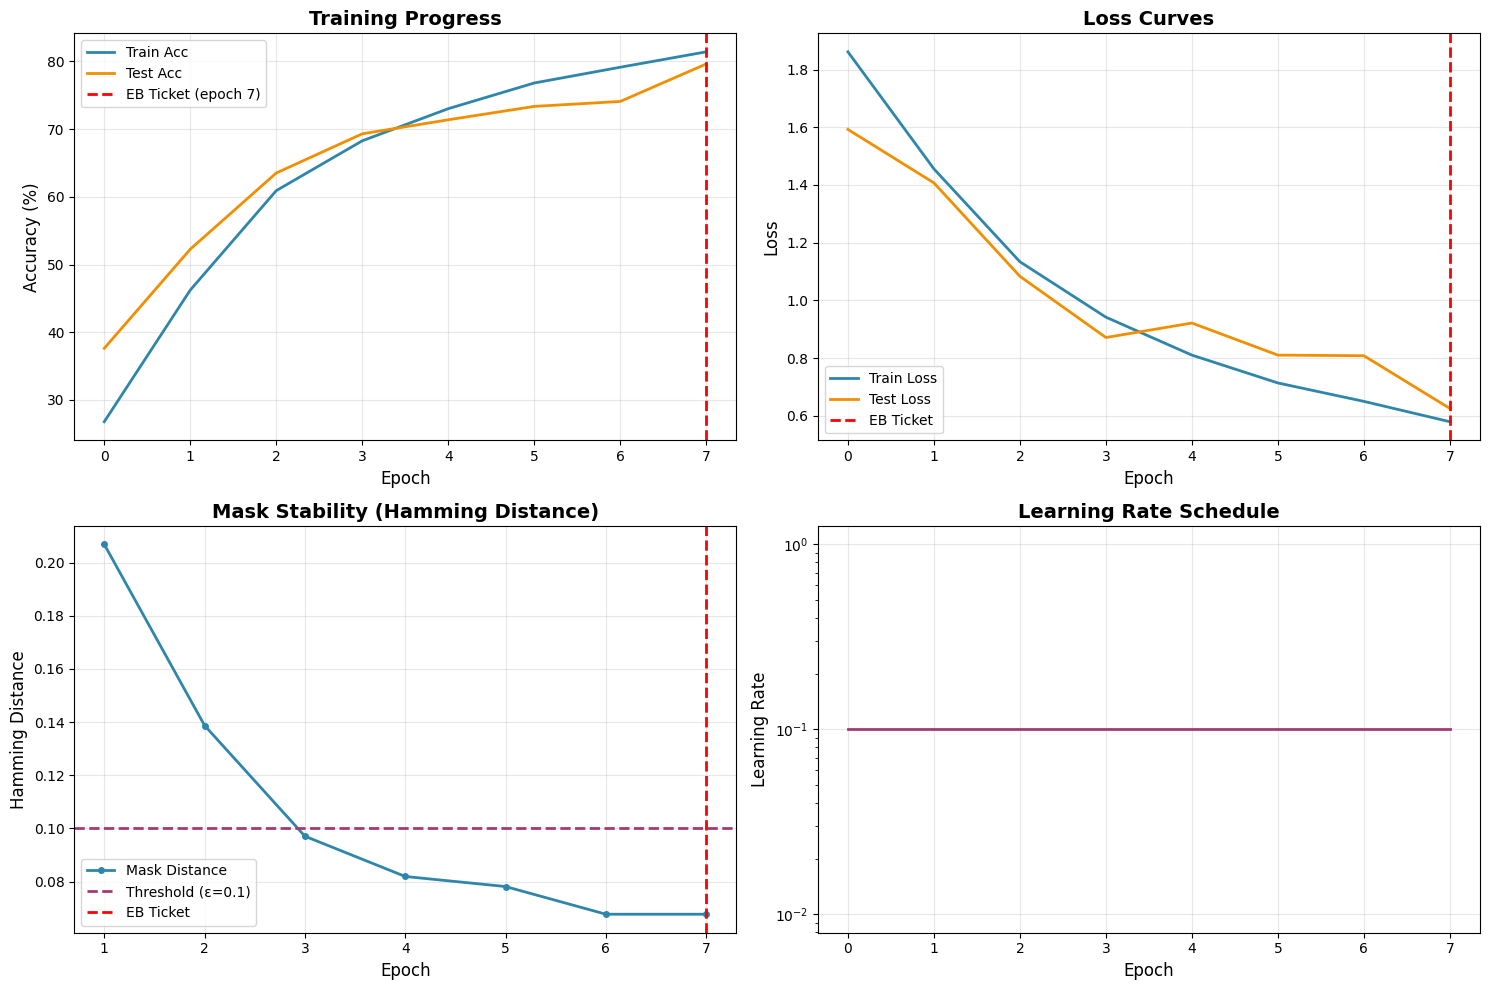


✓ Figure saved to results/earlybird_vgg16_cifar10_search.png


In [9]:
# Plot training history and mask distance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training and Test Accuracy
ax1 = axes[0, 0]
ax1.plot(history['epoch'], history['train_acc'], label='Train Acc', color='#2E86AB', linewidth=2)
ax1.plot(history['epoch'], history['test_acc'], label='Test Acc', color='#F18F01', linewidth=2)
if convergence_epoch is not None:
    ax1.axvline(x=convergence_epoch, color='red', linestyle='--', linewidth=2, 
                label=f'EB Ticket (epoch {convergence_epoch})')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Training Progress', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Training Loss
ax2 = axes[0, 1]
ax2.plot(history['epoch'], history['train_loss'], label='Train Loss', color='#2E86AB', linewidth=2)
ax2.plot(history['epoch'], history['test_loss'], label='Test Loss', color='#F18F01', linewidth=2)
if convergence_epoch is not None:
    ax2.axvline(x=convergence_epoch, color='red', linestyle='--', linewidth=2, label=f'EB Ticket')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Loss Curves', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Mask Distance over epochs
ax3 = axes[1, 0]
distances = history['mask_distance']
valid_distances = [(e, d) for e, d in zip(history['epoch'], distances) if d >= 0]
if valid_distances:
    epochs_valid, dists_valid = zip(*valid_distances)
    ax3.plot(epochs_valid, dists_valid, 'o-', color='#2E86AB', markersize=4, linewidth=2, label='Mask Distance')
    ax3.axhline(y=DISTANCE_THRESHOLD, color='#A23B72', linestyle='--', linewidth=2,
                label=f'Threshold (ε={DISTANCE_THRESHOLD})')
    if convergence_epoch is not None:
        ax3.axvline(x=convergence_epoch, color='red', linestyle='--', linewidth=2, label=f'EB Ticket')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Hamming Distance', fontsize=12)
ax3.set_title('Mask Stability (Hamming Distance)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Learning Rate Schedule
ax4 = axes[1, 1]
ax4.plot(history['epoch'], history['lr'], color='#A23B72', linewidth=2)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Learning Rate', fontsize=12)
ax4.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(ROOT_DIR / 'results' / 'earlybird_vgg16_cifar10_search.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to results/earlybird_vgg16_cifar10_search.png")

## Phase 2: Fine-tune the Pruned Network

After discovering the Early-Bird ticket, we apply the channel mask to prune the network and fine-tune to recover accuracy. The fine-tuning phase trains **without** L1 regularization.

In [10]:
def apply_channel_mask(model, channel_masks, weight_masks):
    """
    Apply channel pruning by zeroing out pruned channels in Conv2d and BN layers.
    In practice, you would reconstruct a smaller network, but for simplicity,
    we zero out the weights corresponding to pruned channels.
    """
    with torch.no_grad():
        # Apply to Conv2d layers
        for name, module in model.named_modules():
            if name in weight_masks:
                mask_tensor = torch.from_numpy(weight_masks[name]).float().to(module.weight.device)
                module.weight.data *= mask_tensor
                
        # Zero out BN parameters for pruned channels
        for name, module in model.named_modules():
            if isinstance(module, nn.BatchNorm2d) and name in channel_masks:
                mask = torch.from_numpy(channel_masks[name]).float().to(module.weight.device)
                module.weight.data *= mask
                module.bias.data *= mask
                module.running_mean *= mask
                module.running_var = module.running_var * mask + (1 - mask) * 1.0  # Avoid div by zero

def train_epoch_standard(model, train_loader, optimizer, criterion, device):
    """Train for one epoch without L1 regularization."""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return total_loss / total, 100.0 * correct / total

print("Fine-tuning functions defined.")

Fine-tuning functions defined.


In [11]:
if eb_ticket is not None:
    print("\n" + "=" * 70)
    print("APPLYING EARLY-BIRD TICKET")
    print("=" * 70)
    
    # Expand channel masks to Conv2d weight masks
    weight_masks = expand_channel_mask_to_conv_weights(eb_ticket, model)
    
    print(f"Channel masks (BN layers): {len(eb_ticket)}")
    print(f"Weight masks (Conv layers): {len(weight_masks)}")
    
    # Apply the mask (zero out pruned channels)
    apply_channel_mask(model, eb_ticket, weight_masks)
    print("✓ Pruning masks applied to model weights")
    
    # Verify sparsity after masking
    total_params = 0
    zero_params = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_params += param.numel()
            zero_params += (param == 0).sum().item()
    
    actual_sparsity = zero_params / total_params * 100
    print(f"Actual weight sparsity: {actual_sparsity:.2f}%")
    
    # Evaluate immediately after pruning
    test_loss_pruned, test_acc_pruned = evaluate(model, test_loader, criterion, device)
    print(f"\nTest accuracy after pruning (before fine-tuning): {test_acc_pruned:.2f}%")
    print("=" * 70)
else:
    print("\n" + "=" * 70)
    print("No Early-Bird ticket found. Skipping fine-tuning.")
    print("=" * 70)


APPLYING EARLY-BIRD TICKET
Channel masks (BN layers): 13
Weight masks (Conv layers): 13
✓ Pruning masks applied to model weights
Actual weight sparsity: 47.63%

Test accuracy after pruning (before fine-tuning): 10.00%


In [12]:
if eb_ticket is not None:
    # Fine-tuning configuration
    FINETUNE_EPOCHS = TOTAL_EPOCHS - convergence_epoch  # Remaining epochs
    
    # Reset optimizer and scheduler for fine-tuning
    # Start with reduced LR based on where we stopped
    finetune_lr = INITIAL_LR
    for milestone in LR_MILESTONES:
        if convergence_epoch >= milestone:
            finetune_lr *= LR_GAMMA
    
    optimizer_ft = optim.SGD(
        model.parameters(),
        lr=finetune_lr,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY
    )
    
    # Adjust milestones relative to convergence epoch
    remaining_milestones = [m - convergence_epoch for m in LR_MILESTONES if m > convergence_epoch]
    scheduler_ft = MultiStepLR(optimizer_ft, milestones=remaining_milestones, gamma=LR_GAMMA)
    
    print("\n" + "=" * 70)
    print("FINE-TUNING PRUNED NETWORK")
    print("=" * 70)
    print(f"Fine-tuning epochs: {FINETUNE_EPOCHS}")
    print(f"Initial fine-tuning LR: {finetune_lr}")
    print(f"Remaining LR milestones: {remaining_milestones}")
    print("=" * 70)
    
    finetune_history = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
    }
    
    best_test_acc = test_acc_pruned
    
    for ft_epoch in range(FINETUNE_EPOCHS):
        global_epoch = convergence_epoch + ft_epoch + 1
        current_lr = optimizer_ft.param_groups[0]['lr']
        
        # Train without L1 regularization
        train_loss, train_acc = train_epoch_standard(
            model, train_loader, optimizer_ft, criterion, device
        )
        
        # Re-apply mask after optimizer step (maintain sparsity)
        apply_channel_mask(model, eb_ticket, weight_masks)
        
        # Evaluate
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        scheduler_ft.step()
        
        # Track history
        finetune_history['epoch'].append(global_epoch)
        finetune_history['train_loss'].append(train_loss)
        finetune_history['train_acc'].append(train_acc)
        finetune_history['test_loss'].append(test_loss)
        finetune_history['test_acc'].append(test_acc)
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
        
        # Print progress (every 10 epochs or last epoch)
        if ft_epoch % 10 == 0 or ft_epoch == FINETUNE_EPOCHS - 1:
            print(f"Epoch {global_epoch:3d} | LR: {current_lr:.6f} | "
                  f"Train: {train_acc:.2f}% (Loss: {train_loss:.4f}) | "
                  f"Test: {test_acc:.2f}% | Best: {best_test_acc:.2f}%")
    
    print("\n" + "=" * 70)
    print("FINE-TUNING COMPLETE!")
    print("=" * 70)
    print(f"Best test accuracy: {best_test_acc:.2f}%")
    print("=" * 70)


FINE-TUNING PRUNED NETWORK
Fine-tuning epochs: 153
Initial fine-tuning LR: 0.1
Remaining LR milestones: [73, 113]
Epoch   8 | LR: 0.100000 | Train: 36.69% (Loss: 1.6095) | Test: 44.59% | Best: 44.59%
Epoch  18 | LR: 0.100000 | Train: 59.63% (Loss: 1.2585) | Test: 52.60% | Best: 60.85%
Epoch  28 | LR: 0.100000 | Train: 58.56% (Loss: 1.2751) | Test: 54.19% | Best: 60.85%
Epoch  38 | LR: 0.100000 | Train: 60.35% (Loss: 1.2788) | Test: 44.84% | Best: 63.34%
Epoch  48 | LR: 0.100000 | Train: 52.81% (Loss: 1.4124) | Test: 46.61% | Best: 63.34%
Epoch  58 | LR: 0.100000 | Train: 53.32% (Loss: 1.3878) | Test: 48.32% | Best: 63.34%
Epoch  68 | LR: 0.100000 | Train: 47.81% (Loss: 1.4490) | Test: 51.38% | Best: 63.34%
Epoch  78 | LR: 0.100000 | Train: 42.69% (Loss: 1.5709) | Test: 47.49% | Best: 63.34%
Epoch  88 | LR: 0.010000 | Train: 67.20% (Loss: 1.0116) | Test: 69.72% | Best: 69.72%
Epoch  98 | LR: 0.010000 | Train: 68.86% (Loss: 0.9775) | Test: 69.83% | Best: 71.26%
Epoch 108 | LR: 0.010000 

## Final Results Summary

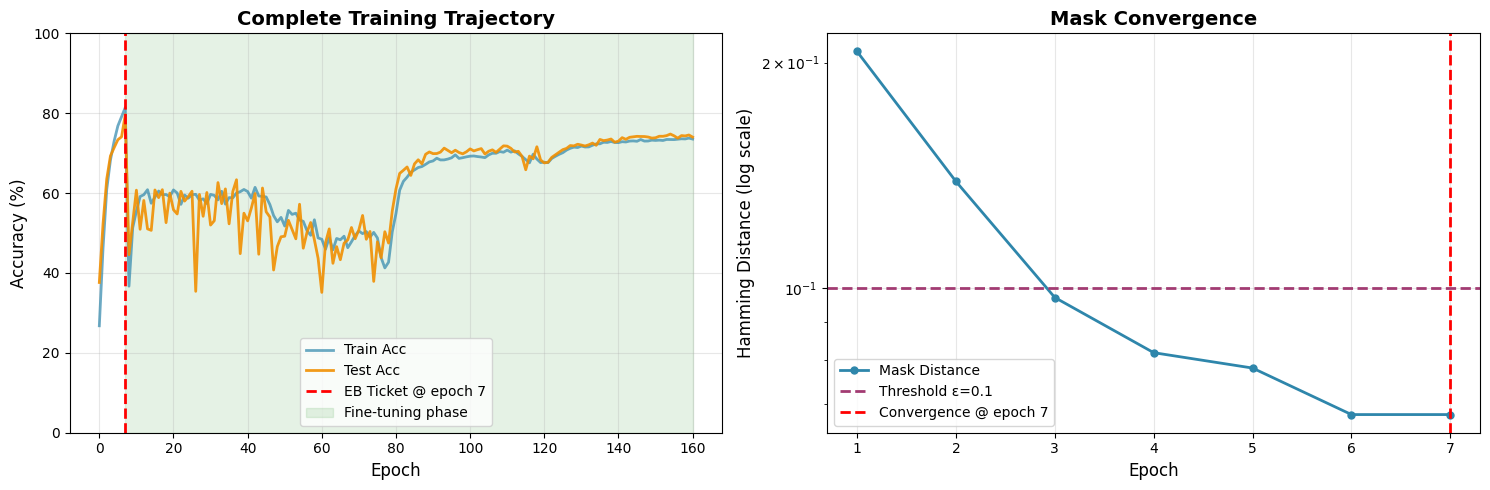


✓ Figure saved to results/earlybird_vgg16_cifar10_complete.png

EARLY-BIRD EXPERIMENT SUMMARY
Model: VGG16-BN
Dataset: CIFAR-10
Target Sparsity: 50%
Early-Bird Ticket Found: Epoch 7
Total Training Epochs (Search + Fine-tune): 161
Training Epochs Saved: 152
----------------------------------------------------------------------
Accuracy at EB discovery: 79.63%
Final Test Accuracy: 74.02%
Best Test Accuracy: 74.78%
Actual Channel Sparsity: 50.00%

Metric                              Value          
--------------------------------------------------
Early-Bird Discovery Epoch          7              
Search Phase Test Acc               79.63%
After Pruning (before FT)           10.00%
Final Test Acc (after FT)           74.02%
Best Test Acc                       74.78%
Accuracy Drop from Search           5.61%
Channel Sparsity                    50.00%
Training Epochs Saved               152


In [13]:
if eb_ticket is not None and 'finetune_history' in dir():
    # Combined plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Full training trajectory
    ax1 = axes[0]
    all_epochs = history['epoch'] + finetune_history['epoch']
    all_train_acc = history['train_acc'] + finetune_history['train_acc']
    all_test_acc = history['test_acc'] + finetune_history['test_acc']
    
    ax1.plot(all_epochs, all_train_acc, label='Train Acc', color='#2E86AB', linewidth=2, alpha=0.7)
    ax1.plot(all_epochs, all_test_acc, label='Test Acc', color='#F18F01', linewidth=2, alpha=0.9)
    ax1.axvline(x=convergence_epoch, color='red', linestyle='--', linewidth=2, 
                label=f'EB Ticket @ epoch {convergence_epoch}')
    ax1.fill_between([convergence_epoch, max(all_epochs)], 0, 100, 
                     alpha=0.1, color='green', label='Fine-tuning phase')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_title('Complete Training Trajectory', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])
    
    # Mask distance with convergence visualization
    ax2 = axes[1]
    valid_distances = [(e, d) for e, d in zip(history['epoch'], history['mask_distance']) if d >= 0]
    if valid_distances:
        epochs_valid, dists_valid = zip(*valid_distances)
        ax2.semilogy(epochs_valid, dists_valid, 'o-', color='#2E86AB', markersize=5, 
                     linewidth=2, label='Mask Distance')
        ax2.axhline(y=DISTANCE_THRESHOLD, color='#A23B72', linestyle='--', linewidth=2,
                    label=f'Threshold ε={DISTANCE_THRESHOLD}')
        ax2.axvline(x=convergence_epoch, color='red', linestyle='--', linewidth=2,
                    label=f'Convergence @ epoch {convergence_epoch}')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Hamming Distance (log scale)', fontsize=12)
    ax2.set_title('Mask Convergence', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(ROOT_DIR / 'results' / 'earlybird_vgg16_cifar10_complete.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Figure saved to results/earlybird_vgg16_cifar10_complete.png")
    
    # Print summary table
    print("\n" + "=" * 70)
    print("EARLY-BIRD EXPERIMENT SUMMARY")
    print("=" * 70)
    print(f"Model: VGG16-BN")
    print(f"Dataset: CIFAR-10")
    print(f"Target Sparsity: {TARGET_SPARSITY * 100:.0f}%")
    print(f"Early-Bird Ticket Found: Epoch {convergence_epoch}")
    print(f"Total Training Epochs (Search + Fine-tune): {max(all_epochs) + 1}")
    print(f"Training Epochs Saved: {TOTAL_EPOCHS - convergence_epoch - 1}")
    print("-" * 70)
    print(f"Accuracy at EB discovery: {history['test_acc'][-1]:.2f}%")
    print(f"Final Test Accuracy: {finetune_history['test_acc'][-1]:.2f}%")
    print(f"Best Test Accuracy: {best_test_acc:.2f}%")
    print(f"Actual Channel Sparsity: {get_overall_channel_sparsity(eb_ticket) * 100:.2f}%")
    print("=" * 70)
    
    # Summary statistics table
    print(f"\n{'Metric':<35} {'Value':<15}")
    print("-" * 50)
    print(f"{'Early-Bird Discovery Epoch':<35} {convergence_epoch:<15}")
    print(f"{'Search Phase Test Acc':<35} {history['test_acc'][-1]:.2f}%")
    print(f"{'After Pruning (before FT)':<35} {test_acc_pruned:.2f}%")
    print(f"{'Final Test Acc (after FT)':<35} {finetune_history['test_acc'][-1]:.2f}%")
    print(f"{'Best Test Acc':<35} {best_test_acc:.2f}%")
    print(f"{'Accuracy Drop from Search':<35} {(history['test_acc'][-1] - finetune_history['test_acc'][-1]):.2f}%")
    print(f"{'Channel Sparsity':<35} {get_overall_channel_sparsity(eb_ticket) * 100:.2f}%")
    print(f"{'Training Epochs Saved':<35} {TOTAL_EPOCHS - convergence_epoch - 1}")

## Quick Test Mode (Optional)

Run a shorter test with reduced epochs to verify the implementation works correctly before full training.

In [14]:
# Quick test with minimal epochs to verify implementation
# Set QUICK_TEST = True to run a fast verification

QUICK_TEST = False  # Change to True for quick verification

if QUICK_TEST:
    print("Running quick test mode (5 epochs)...")
    
    # Small model for quick test
    quick_model = VGG16_BN(num_classes=10).to(device)
    quick_optimizer = optim.SGD(quick_model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    quick_criterion = nn.CrossEntropyLoss()
    
    quick_finder = EarlyBirdFinder(
        target_sparsity=0.5,
        patience=2,  # Lower patience for quick test
        distance_threshold=0.2,  # Higher threshold for quick test
        pruning_method='global'
    )
    
    for epoch in range(5):
        train_loss, l1_loss, train_acc = train_epoch_with_l1(
            quick_model, train_loader, quick_optimizer, quick_criterion, 1e-4, device
        )
        test_loss, test_acc = evaluate(quick_model, test_loader, quick_criterion, device)
        converged, dist = quick_finder.record_epoch(quick_model, epoch)
        
        print(f"Epoch {epoch}: Train {train_acc:.2f}% | Test {test_acc:.2f}% | Dist {dist:.4f}")
        
        if converged:
            print(f"✓ Quick test: EB ticket found at epoch {epoch}")
            break
    
    print("\n✓ Quick test completed successfully!")
    print("The implementation is working. Set QUICK_TEST = False and re-run for full training.")